# Gaussian Convolution

In this workbook we want to test a method for convolving an elliptical PSF to a circular one. One question that remains is: is it possible to convolve the Psf with a Gaussian, such that the resulting Gaussian is circular with a radius that matches the PSF.

In [1]:
import sys,os
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('../'))

import warnings
warnings.filterwarnings("ignore")

# Scipy stuff:
import scipy.optimize as opt

# Astropy stuff:
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
from astropy import wcs
from astropy.io import fits
from astropy.io.votable import parse_single_table
from astropy.table import Table,Column,vstack
from astropy.io.votable import writeto as writetoVO
from astropy.visualization import astropy_mpl_style
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename
from scipy import ndimage, misc


# Image processing packages:
from skimage.feature import blob_dog
from skimage.feature import blob_log

# Array module.
import numpy as np

# Module for fitting SNRs
from snrfit import NGaussian2D,SNR_Gauss_fit,determine_peaks_bkg
import snrfit

# For downlaoding images.
import gleam_client

### Loading in a test PSF.

In [2]:
path = '../data/'
#path = '../SNRfit/data/'

filename = 'RA225.71_DEC-41.93_170-231MHz.fits'
#filename = 'SNR228_170-231MHz.fits'
#filename = 'SNR175_170-231MHz.fits'

warnings.filterwarnings("ignore")
with fits.open(path+filename) as hdul:
    #hdul.info()
    header = hdul[0].header
    img_arr = hdul[0].data#[0,0,:,:]


image = np.ones(img_arr.shape)*img_arr

a_psf = header['BMAJ']
b_psf = header['BMIN']
theta_psf = np.radians(header['BPA'])

X = np.shape(img_arr)[0]
Y = np.shape(img_arr)[1]
print('Image shape (%s,%s)' % (X,Y))

# Defining the pixel grids.
x_pix = np.arange(X)
y_pix = np.arange(Y)
xx_pix, yy_pix = np.meshgrid(x_pix,y_pix)

# This is the pixel scale in degrees.
dx = np.abs(header['CD1_1']) #pixel scale in degrees [deg]

print('dx = %5.3e [deg]' % dx)

w = WCS(header).celestial

Image shape (129,129)
dx = 7.697e-03 [deg]


In [3]:
a_psf = 1.5*a_psf

### Plotting the PSF.

Image pixel center = (64.667, 64.667)
sig_psf_x = 3.064 [pix], sig_psf_y = 1.993 [pix]
semi-major = 3.607 [pix], semi-minor = 2.346 [pix]


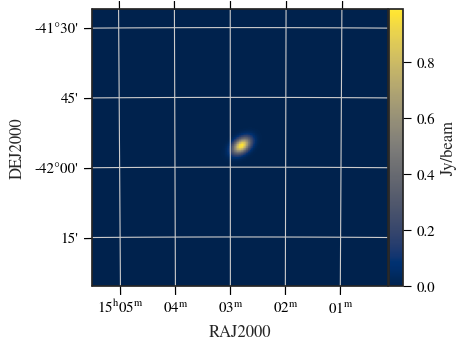

sig_x_nu = 2.327 [pix], sig_y_nu = 0.500 [pix]


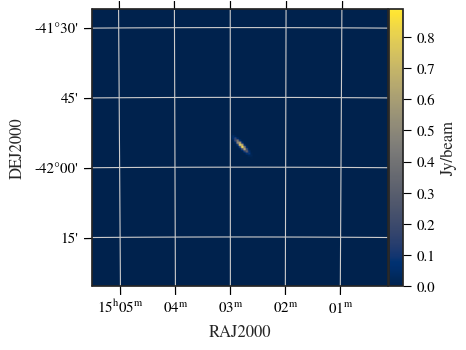

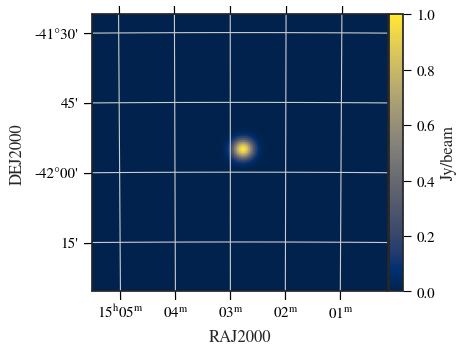

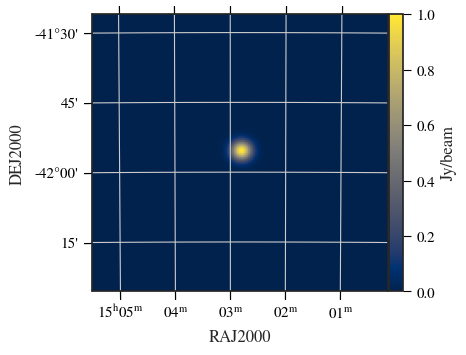

In [4]:
RA_SN1006 = header['CRVAL1']
DEC_SN1006 = header['CRVAL2']

# Getting the corresponding pixel coordinates for the image centre.
x_cent,y_cent = w.wcs_world2pix(RA_SN1006,DEC_SN1006,1)
print('Image pixel center = (%5.3f, %5.3f)' % (x_cent,y_cent))

sigx_psf = (1/dx)*a_psf/(2*np.sqrt(2*np.log(2))) 
sigy_psf = (1/dx)*b_psf/(2*np.sqrt(2*np.log(2))) 

print(f'sig_psf_x = {sigx_psf:5.3f} [pix], sig_psf_y = {sigy_psf:5.3f} [pix]')
print(f'semi-major = {0.5*a_psf/dx:5.3f} [pix], semi-minor = {0.5*b_psf/dx:5.3f} [pix]')

p_psf = np.array([1,x_cent,y_cent,sigx_psf,sigy_psf,theta_psf])

zz_psf = NGaussian2D((xx_pix,yy_pix),p_psf,fit=False).reshape(X, Y)

snrfit.astro_plot_2D(zz_psf, w, figsize=(7.5,6),scale=0.6)

dx_pix = 1.
sigx_nu = np.sqrt((sigx_psf**2-sigy_psf**2))
sigy_nu = dx_pix/2

print(f'sig_x_nu = {sigx_nu:5.3f} [pix], sig_y_nu = {sigy_nu:5.3f} [pix]')

theta_nu = theta_psf+np.pi/2

p_nu = np.array([1,x_cent,y_cent,sigx_nu,sigy_nu,theta_nu])

zz_nu = NGaussian2D((xx_pix,yy_pix),p_nu,fit=False).reshape(X, Y)

snrfit.astro_plot_2D(zz_nu, w, figsize=(7.5,6),scale=0.6)

from scipy.signal import convolve2d

zz_circ = convolve2d(zz_psf,zz_nu,mode='same',boundary='wrap')

zz_circ = zz_circ/np.max(zz_circ)

snrfit.astro_plot_2D(zz_circ, w, figsize=(7.5,6),scale=0.6)

p_circ = np.array([1,x_cent,y_cent,sigx_psf,sigx_psf,0])

zz_circ_2 = NGaussian2D((xx_pix,yy_pix),p_circ,fit=False).reshape(X, Y)

zz_circ_2 = zz_circ_2/np.max(zz_circ_2)

snrfit.astro_plot_2D(zz_circ_2, w, figsize=(7.5,6),scale=0.6)


0.19166961676752658
0.0


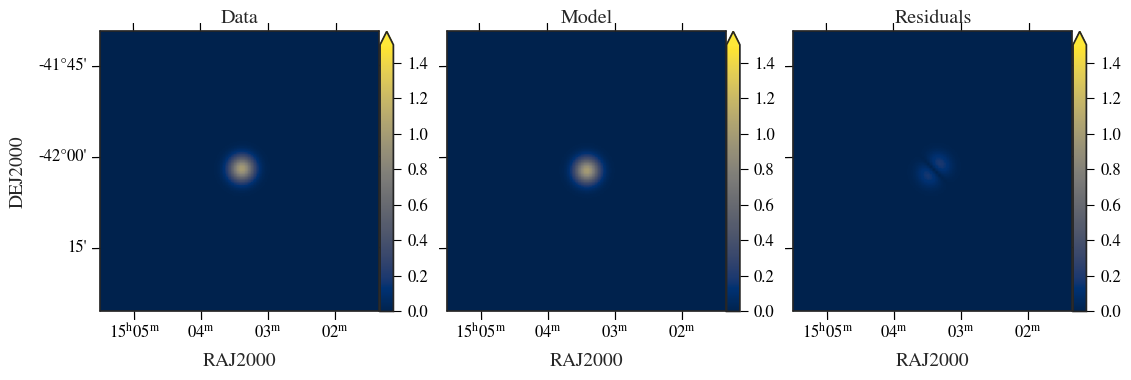

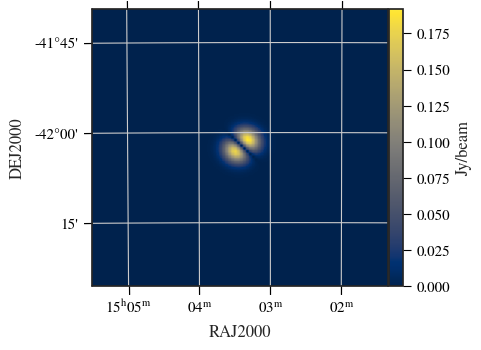

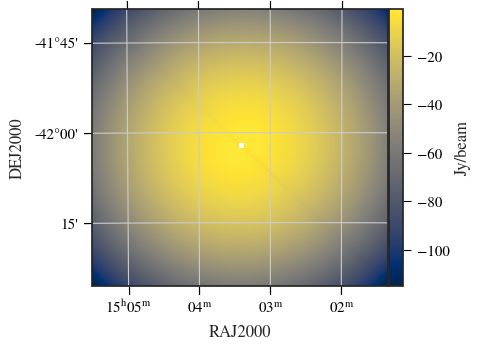

In [10]:
N = image.shape[0]
N_cent = int(N/2) + 1
dN = 50

anal_subset = zz_circ_2[N_cent-dN:N_cent+dN,N_cent-dN:N_cent+dN]
conv_subset = zz_circ[N_cent-dN:N_cent+dN,N_cent-dN:N_cent+dN]#[::-1,::-1]

Ratio = anal_subset/conv_subset

comparison = np.abs((anal_subset-conv_subset))

print(np.max(comparison))
print(np.min(comparison))

#img_list = [zz_circ_2,zz_circ,Ratio]
img_list = [anal_subset,conv_subset,comparison]

#snrfit.array_plot(img_list,w,scale=0.7)
snrfit.point_plot(anal_subset,conv_subset,comparison,w,scale=0.7,vmax=1.5)
snrfit.astro_plot_2D(comparison, w, figsize=(7.5,6),scale=0.6)
snrfit.astro_plot_2D(np.log10(comparison), w, figsize=(7.5,6),scale=0.6)